# Higgs Boson Search

## Imports

In [59]:
import uproot
import os
from tqdm import tqdm
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from scipy.stats import binned_statistic
from scipy.special import factorial
from scipy.optimize import minimize
from time import sleep
import winsound
import matplotlib.colors as mcolors

# Event class


In [2]:
@dataclass
class Event:
    """
    Class for structuring the data to be stored in pandas datafram since
    dataclass and pandas are compatible
    """
    # Define parameters that are stored
    l1_pt: float
    l2_pt: float
    l3_pt: float
    l4_pt: float
    
    l1_mass: float
    l2_mass: float
    l3_mass: float
    l4_mass: float
        
    l1_eta: float
    l2_eta: float
    l3_eta: float
    l4_eta: float
        
    l1_phi: float
    l2_phi: float
    l3_phi: float
    l4_phi: float
    
    # What leptons the event is form
    event_type: str
    # What the weight is, relevant for simulated
    weight: float
    
    invariant_mass: float = 0
    invariant_mass_1: float = 0
    invariant_mass_2: float = 0
    
        
    def __init__(self, muon_pt, muon_mass, muon_eta, muon_phi,
                 electron_pt, electron_mass, electron_eta, electron_phi,
                 i1, i2, i3, i4, weight, event_type):
        
        self.event_type = event_type
        # Have four muons as input
        if event_type == "4Muon":
            muon4 = True
        else:
            muon4 = False

        if muon4 == True:
            self.l1_pt = muon_pt[i1] 
            self.l2_pt = muon_pt[i2]
            self.l3_pt = muon_pt[i3]
            self.l4_pt = muon_pt[i4]
            
            self.l1_mass = muon_mass[i1] 
            self.l2_mass = muon_mass[i2]
            self.l3_mass = muon_mass[i3]
            self.l4_mass = muon_mass[i4]
            
            self.l1_eta = muon_eta[i1] 
            self.l2_eta = muon_eta[i2]
            self.l3_eta = muon_eta[i3]
            self.l4_eta = muon_eta[i4]
            
            self.l1_phi = muon_phi[i1] 
            self.l2_phi = muon_phi[i2]
            self.l3_phi = muon_phi[i3]
            self.l4_phi = muon_phi[i4]
        else:
            self.l1_pt = muon_pt[i1] 
            self.l2_pt = muon_pt[i2]
            self.l3_pt = electron_pt[i3]
            self.l4_pt = electron_pt[i4]
        
            self.l1_mass = muon_mass[i1] 
            self.l2_mass = muon_mass[i2]
            self.l3_mass = electron_mass[i3]
            self.l4_mass = electron_mass[i4]
            
            self.l1_eta = muon_eta[i1] 
            self.l2_eta = muon_eta[i2]
            self.l3_eta = electron_eta[i3]
            self.l4_eta = electron_eta[i4]
            
            self.l1_phi = muon_phi[i1] 
            self.l2_phi = muon_phi[i2]
            self.l3_phi = electron_phi[i3]
            self.l4_phi = electron_phi[i4]
        self.weight = weight
        self.__post_init__()
            
    def __post_init__(self):
        """Get called after init to construct inveriant mass outside init"""
        M2p1 = 2*self.l1_pt*self.l2_pt*(
            np.cosh(self.l1_eta - self.l2_eta) - np.cos(self.l1_phi - self.l2_phi)
        )+ self.l1_mass**2 + self.l2_mass**2

        M2p2 = 2*self.l3_pt*self.l4_pt*(
            np.cosh(self.l3_eta - self.l4_eta) - np.cos(self.l3_phi - self.l4_phi)
        )+ self.l3_mass**2 + self.l4_mass**2
        
        
        self.invariant_mass_1 = np.sqrt(M2p1)
        self.invariant_mass_2 = np.sqrt(M2p2)

        invariant_mass = 0
        pt_list = [self.l1_pt, self.l2_pt, self.l3_pt, self.l4_pt]
        eta_list = [self.l1_eta, self.l2_eta, self.l3_eta, self.l4_eta]
        phi_list = [self.l1_phi, self.l2_phi, self.l3_phi, self.l4_phi]
        
        for i, (pt_1, eta_1, phi_1) in enumerate(zip(pt_list, eta_list, phi_list)):
            for pt_2, eta_2, phi_2 in zip(pt_list[i+1:], eta_list[i+1:], phi_list[i+1:]):
                invariant_mass += 2*pt_1*pt_2*(np.cosh(eta_1 - eta_2)- np.cos(phi_1 - phi_2))
                # invariant_mass += 2*pt_1*pt_2*(1 - np.cos(phi_1 - phi_2))
        invariant_mass += self.l1_mass**2 + self.l2_mass**2 + self.l3_mass**2 + self.l4_mass**2
        
        self.invariant_mass = np.sqrt(invariant_mass)


# Reading files and filtering data

Filters in use:
1. Each lepton taken into account have to have atleast a $p_t > 5$Gev to be taken as valid.
1. All events have to have at least 2 muons.
2. The muon with lergest $p_t$ has $p_t > 20$ GeV and the other has $p_t > 10$GeV.
3. Them muons have to be isolated, this means a pfRelIso03_all$< 0.15$ for both of them.
4. The signs of the leptons that are assosiated to eachother have to be oposite, and offcourse same flavor.
5. The pair with largest invariant mass have to be in an interval of $10$Gev of the Z boson mass $91$ and the other pair have to have a inveriant mass lower than this.
6. Each simulated event is assigned a weigth according to eventWeightLumi, which is callculated from $\frac{\sigma L}{N}$.

Note: A pair refferes to two leptons of same flavor with oppsite charge. 

Making the pairs:
- When just two of each flavor check if they match
- When three in one flavor the pair with the invariant mass that satisfies the correct invariant mass is choosen
- When four or more the pairs are group by invariant mass the one corresponding the the correct invariant mass is choosen as first pair. If the other pairs have invariant mass greater than the Z mass they are discarded. If other flavor is also present the one with the highest invariant mass of the pairs is choosen. 


In [194]:
@dataclass
class FileRead:
    """
    Class to interact with the root files and the dataframes
    from the filtered data.
    """

    # names of variables to be used from root files
    names  = [
        "Electron_mass",
        "Electron_charge",
        "Electron_pt",
        "Electron_cutBased", 
        "Electron_eta",
        "Electron_phi",
        "Electron_pfRelIso03_all",
        "Muon_charge",
        "Muon_mass",
        "Muon_pt",
        "Muon_tightId",
        "Muon_pt",
        "Muon_mass",
        "Muon_eta",
        "Muon_phi",
        "Muon_pfRelIso03_all",
        "eventWeightLumi"
        ]

    # names of triggers to be used from root files
    trigger_names  = [
        "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL",
        "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8",
        "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8"
    ]

    # Parameters for filtering the data
    min_muon : float = 2 # minum number of muon in event
    min_muon_pt_1 : float = 20 # Minimum pt of muon with largest 
    min_muon_pt_2 : float = 10 # Minimum pt of muon with second largets
    min_lepton_pt : float = 5 # Minimum pt of accepted leptons
    max_isolated : float = 0.15 # Max isolation value
    Z_mass : float = 91 # Z_mass to for first pair
    pair1_mass_max : float = 106 # Maximum value of first lepton pair
    pair1_mass_min : float = 50 # Min value of first lepton pair
    Z_off_mass : float = 115 # The target value of second pair closest to this is exepted
    pair2_mass_max : float = 115 # Maximum value of second lepton pair
    pair2_mass_min : float = 14 # Min value of second lepton pair
    electron_quality_min : float = 2 # The cutBased quality of electron have to be strictly larger than this

    # Tags for the different type of lepton pairing
    muon4_tag = "4Muon" # all 4 leptons are muons
    muon2electron2_tag = "2Muon2Electron" # the on shell pair is muons and other electrons
    electron2muon2_tag = "2Electron2Muon" # the on shell pair is electrons and other muons

    # paths for loading and storing data
    start_path = os.path.join(os.getcwd(),"root_data") # root data location
    save_filtered_data = os.path.join(os.getcwd(),"f_data") # filtered data location

    # parameters for controling the binning
    bin_size : float = 2.5 # bin size
    bin_min : float = 80 # bin minimum value
    bin_max : float = 300 # bin maximum value
    
    def __post_init__(self):
        """ Constructs the binning post init to allow for user to set"""
        self.bins = np.arange(self.bin_min, self.bin_max, self.bin_size)

    
    def read(cls,file_path):
        """ 
        Reads a single root file and returns a pandas dataframe
        with all the kept events.
        """

        # Open the file with uproot
        with uproot.open(file_path)["Events"] as events:
            
            # get variables and store in dictionary
            variable_dict = cls.get_variables(events)

            # storage for events
            accepted_events = []
            # iterate through all the events in the file
            for i in range(variable_dict["size"]):
                
                #### Checking triggers and filter ####

                # Checking triggers
                trigger_list = [variable_dict[trigger][i] for trigger in cls.trigger_names]
                # Logical or of them 
                if sum(trigger_list) == 0:
                    continue
                
            
                # Assigning values from the dictionary
                weight = variable_dict["eventWeightLumi"][i]          
                
                muon_pt = variable_dict["Muon_pt"][i]
                electron_pt = variable_dict["Electron_pt"][i]
                
                electron_cutBased = variable_dict["Electron_cutBased"][i]
                muon_tightId = variable_dict["Muon_tightId"][i]

                electron_iso = variable_dict["Electron_pfRelIso03_all"][i]
                muon_iso = variable_dict["Muon_pfRelIso03_all"][i]

                # Require atleast 2 muons
                if len(muon_pt) < 2:
                    continue

                # Require muon pt criterias
                if muon_pt[0] < cls.min_muon_pt_1:
                    continue
                if muon_pt[1] < cls.min_muon_pt_2:
                    continue

                # Require the the two largest momentum muons are isolated
                if (muon_iso[0] > cls.max_isolated) or (muon_iso[1] > cls.max_isolated):
                    continue

                # Filtering out leptons that are not of valid quality or have to low pt
                muon_keep = (muon_pt > cls.min_lepton_pt)*(muon_iso < cls.max_isolated)*muon_tightId
                electron_keep = (electron_pt > cls.min_lepton_pt)*(electron_iso < cls.max_isolated)*(electron_cutBased > cls.electron_quality_min)
                
                # Removing the leptons that wheren't valid
                muon_pt = muon_pt[muon_keep]
                muon_charge = variable_dict["Muon_charge"][i][muon_keep]
                electron_pt = electron_pt[electron_keep]
                electron_charge = variable_dict["Electron_charge"][i][electron_keep]
                
                
                
                # Check that there are enough pairs
                num_electron_pairs = len(electron_pt) //2 - np.floor(abs(np.sum(electron_charge))/2)
                num_muon_pairs = len(muon_pt)//2 - np.floor(abs(np.sum(muon_charge))/2)
                num_pairs = num_electron_pairs + num_muon_pairs
                if num_muon_pairs < 1:
                    continue
                if num_pairs < 2:
                    continue
                
                    
                # Assigning variables to be used in pair making that is not yet assigned                
                muon_eta = variable_dict["Muon_eta"][i][muon_keep]
                muon_phi = variable_dict["Muon_phi"][i][muon_keep]
                muon_mass = variable_dict["Muon_mass"][i][muon_keep]
                
                electron_eta = variable_dict["Electron_eta"][i][electron_keep]
                electron_phi = variable_dict["Electron_phi"][i][electron_keep]
                electron_mass = variable_dict["Electron_mass"][i][electron_keep]
                
                
                
                # Making all the possible pairs of leptons
                muon_invariant_masses = cls.get_pairs_with_mass(muon_charge, muon_pt, muon_eta, muon_phi, muon_mass)
                electron_invariant_masses = cls.get_pairs_with_mass(electron_charge, electron_pt, electron_eta, electron_phi, electron_mass)
                
                # Checking if any muon pair are onshell within the limits, if not no_muon is true
                muon_allowed_masses = (muon_invariant_masses[:,-1] < cls.pair1_mass_max)*(muon_invariant_masses[:,-1] > cls.pair1_mass_min)
                no_muon = True
                if sum(muon_allowed_masses) > 0:
                    no_muon = False
                    # If any allowed store the "most" onshell
                    best_muon_invariant_mass_diff = np.min(np.abs(muon_invariant_masses[muon_allowed_masses,-1]- cls.Z_mass))

                # Checking if any electron pair are onshell within the limits, if not no_electon is true
                no_electron = False
                if len(electron_invariant_masses) > 0:
                    # There are electons so can see if any allowed
                    electron_allowed_masses = (electron_invariant_masses[:,-1] < cls.pair1_mass_max)*(electron_invariant_masses[:,-1] > cls.pair1_mass_min)
                    # If any allowed store the "most" onshell
                    if sum(electron_allowed_masses) > 0:
                        best_electron_invariant_mass_diff = np.min(np.abs(electron_invariant_masses[electron_allowed_masses,-1]- cls.Z_mass))
                    else:
                        no_electron = True
                else:
                    no_electron = True
                
                #### Making pairs ####

                if no_electron and no_muon:
                    # No pairs possible
                    continue

                if not no_electron and no_muon:
                    # Onshell pair is a electon pair
                    
                    # Store the value of electron pair 
                    pair_1 = np.where(np.abs(electron_invariant_masses[:,-1]- cls.Z_mass) == best_electron_invariant_mass_diff)[0]
                    i1 = int(electron_invariant_masses[pair_1[0],0])
                    i2 = int(electron_invariant_masses[pair_1[0],1])
                    
                    # Since the second pair must be muon search through the muon pair invariant masses for best if any
                    i3, i4, _, found = cls.find_2pair(muon_invariant_masses, electron_invariant_masses, electron_live = False) # no electron as second since first
                    
                    # Store the event if a second pair was found
                    if found:
                        accepted_events.append(Event(muon_pt,muon_mass,muon_eta,muon_phi,
                                        electron_pt, electron_mass, electron_eta, electron_phi,
                                        i3,i4,i1,i2,weight, cls.electron2muon2_tag))
                        continue
                    continue
                
                if no_electron and not no_muon:
                    # Onshell pair is a muon pair

                    # Store the value of the muon pair
                    pair_1 = np.where(np.abs(muon_invariant_masses[:,-1]- cls.Z_mass) == best_muon_invariant_mass_diff)[0]
                    i1 = int(muon_invariant_masses[pair_1[0],0])
                    i2 = int(muon_invariant_masses[pair_1[0],1])

                    # remove the pairs from the list that one of the first was part of
                    muon_invariant_masses = cls.remove_indicies(muon_invariant_masses, i1, i2)
                    
                    # search for a second pair, now it can be both electron or muon
                    i3, i4, electron_found, found = cls.find_2pair(muon_invariant_masses, electron_invariant_masses)
                    # check if pair was found
                    if found:
                        # check weather it was an electron or muon pair that was found
                        if electron_found:
                            # Electron pair as second found
                            accepted_events.append(Event(muon_pt,muon_mass,muon_eta,muon_phi,
                                        electron_pt, electron_mass, electron_eta, electron_phi,
                                        i1,i2,i3,i4,weight, cls.muon2electron2_tag))
                            continue
                        
                        else:
                            # Muon pair as second found
                            accepted_events.append(Event(muon_pt,muon_mass,muon_eta,muon_phi,
                                        electron_pt, electron_mass, electron_eta, electron_phi,
                                        i1,i2,i3,i4,weight, cls.muon4_tag))
                            continue
                    continue

                if not no_electron and not no_muon:
                    # Both electron and muon pair can be onshell os choose the one closest as first pair
                    muon_best = best_electron_invariant_mass_diff < best_electron_invariant_mass_diff

                    if muon_best:
                        # The muon pair is the "most" onshell

                        # store value of muon pair
                        pair_1 = np.where(np.abs(muon_invariant_masses[:,-1]- cls.Z_mass) == best_muon_invariant_mass_diff)[0]
                        i1 = int(muon_invariant_masses[pair_1[0],0])
                        i2 = int(muon_invariant_masses[pair_1[0],1])

                        # remove the pairs from the list that one of the first was part of
                        muon_invariant_masses = cls.remove_indicies(muon_invariant_masses, i1, i2)
                        
                        # search for a second pair, now it can be both electron or muon
                        i3, i4, electron_found, found = cls.find_2pair(muon_invariant_masses, electron_invariant_masses)
                        # check what pair was found 
                        if found:
                            if electron_found:
                                # electonr pair found as second pair
                                accepted_events.append(Event(muon_pt,muon_mass,muon_eta,muon_phi,
                                            electron_pt, electron_mass, electron_eta, electron_phi,
                                            i1,i2,i3,i4,weight, cls.muon2electron2_tag))
                                continue
                            
                            else:
                                # muon pair found as second pair
                                accepted_events.append(Event(muon_pt,muon_mass,muon_eta,muon_phi,
                                            electron_pt, electron_mass, electron_eta, electron_phi,
                                            i1,i2,i3,i4,weight, cls.muon4_tag))
                                continue
                        continue
                    
                    else:
                        # The Electron pair is the "most" onshell

                        # Store values of electron pair
                        pair_1 = np.where(np.abs(electron_invariant_masses[:,-1]- cls.Z_mass) == best_electron_invariant_mass_diff)[0]
                        i1 = int(electron_invariant_masses[pair_1[0],0])
                        i2 = int(electron_invariant_masses[pair_1[0],1])
                        
                        # Since the second pair must be muon search through the muon pair invariant masses for best if any
                        i3, i4, _, found = cls.find_2pair(muon_invariant_masses, electron_invariant_masses, electron_live = False) # no electron as second since first

                        # Check if a muon pair if found and store if
                        if found:
                            accepted_events.append(Event(muon_pt,muon_mass,muon_eta,muon_phi,
                                            electron_pt, electron_mass, electron_eta, electron_phi,
                                            i3,i4,i1,i2,weight, cls.electron2muon2_tag))
                            continue
                        continue
        
        # return the accepted events as a dataframe since they are a class made
        # by the dataclass decorator the pandas knows how to store them
        return pd.DataFrame(accepted_events)
    

    def read_list(cls,file_paths,**kwargs):
        """
        Reads a whole list of filepaths and returns a dataframe of all acepted events
        calls the read funciton repeted times
        """
        accepted_events = pd.DataFrame()
        for file_path in tqdm(file_paths):
            accepted_events = pd.concat([accepted_events,cls.read(file_path,**kwargs)])
        
        return accepted_events

    
    def find_2pair(cls, muon_invariant_masses, electron_invariant_masses, electron_live = True):
        """
        The electron live argument controls if electrons should be considered or not. 
        Finds the second pair from the invarant mass arrays, it returns the indices and bool for if electron ( True if electron) and bool for sucsess (True if pair is found).
        e.i. i3, i4, electron_found, pair_fonud
        """
        # Check if there is a possible muon pair
        muon_live = True
        if len(muon_invariant_masses) > 0:
            muon_alowed_pairs = (muon_invariant_masses[:,-1] < cls.pair2_mass_max)*(muon_invariant_masses[:,-1] > cls.pair2_mass_min)
            if sum(muon_alowed_pairs) == 0:
                muon_live = False
        else:
            muon_live = False

        # Check if there is a possible electron pair
        if len(electron_invariant_masses) > 0:
            electron_alowed_pairs = (electron_invariant_masses[:,-1] < cls.pair2_mass_max)*(electron_invariant_masses[:,-1] > cls.pair2_mass_min)
            if sum(electron_alowed_pairs) == 0:
                electron_live = False
        else:
            electron_live = False


        if (not electron_live) and (not muon_live):
            # No posible pair
            return 0,0,True, False

        if (not electron_live) and muon_live:
            # Only muon pair to consider, return the one that's closest to Z_off_mass
            pair_2 = np.argmin(np.abs(muon_invariant_masses[muon_alowed_pairs,-1]- cls.Z_off_mass))
            return int(muon_invariant_masses[pair_2,0]),int(muon_invariant_masses[pair_2,1]), False, True
        
        if electron_live and (not muon_live):
            # Only electron pair to consider, return the one that's closest to Z_off_mass
            pair_2 = np.argmin(np.abs(electron_invariant_masses[electron_alowed_pairs,-1]- cls.Z_off_mass))
            return int(electron_invariant_masses[pair_2,0]),int(electron_invariant_masses[pair_2,1]), True, True
        
        # Both are active so finde the best candidates
        best_muon = np.min(np.abs(muon_invariant_masses[muon_alowed_pairs,-1]- cls.Z_off_mass))
        best_electron = np.min(np.abs(electron_invariant_masses[electron_alowed_pairs,-1]- cls.Z_off_mass))
        
        # Chose the best one 
        if best_electron < best_muon:
            # electron pair is best
            pair_2 = np.argmin(np.abs(electron_invariant_masses[electron_alowed_pairs,-1]- cls.Z_off_mass))
            return int(electron_invariant_masses[pair_2,0]),int(electron_invariant_masses[pair_2,1]), True, True

        if best_electron > best_muon:
            # muon pair is best
            pair_2 = np.argmin(np.abs(muon_invariant_masses[muon_alowed_pairs,-1]- cls.Z_off_mass))
            return int(muon_invariant_masses[pair_2,0]),int(muon_invariant_masses[pair_2,1]), False, True
        
        # Safty if nothing if found
        return 0,0,True, False


    def remove_indicies(cls,invariant_masses,k,l):
        """Remoes the row with certain indicies from the invariant mass list,
        k is remove from positive and l from negative"""

        # Find the indices where the the k and l values are not pressent
        # both for the negative and the positve lepton
        not_positive = np.where(invariant_masses[:,0] != k)[0]
        not_negative = np.where(invariant_masses[:,1] != l)[0]

        # Keep only the pairs that neither the positive nor the negative
        # are part of
        keep = np.intersect1d(not_positive, not_negative)
        invariant_masses = invariant_masses[keep,:]

        return invariant_masses
    
    
    def invariant_mass(self,l_pt, l_eta, l_phi,l_mass, i1, i2):
        """
        Computes the invariant mass of one pair of leptons
        l_pt, l_eta, l_phi, l_mass are np.arrays and i1, i2
        are the indices of what pair in the array should be 
        computed
        """
        return np.sqrt(
            2*l_pt[i1]*l_pt[i2]*(
                np.cosh(l_eta[i1]-l_eta[i2])- np.cos(l_phi[i1]-l_phi[i2])
            ) + l_mass[i1]**2 + l_mass[i2]**2
        )

    
    
    
    def get_pairs_with_mass(cls,l_charge, l_pt, l_eta, l_phi, l_mass):
        """ 
        returns and 2D-array with the possible pair of leptons
        the first coulomn is the positive lepton 
        the second coulomn is the negative lepton and
        the last is the invariant mass of that pair
        """

        # find indices of positive and negative leptons
        positive = np.where(l_charge == 1)[0]
        negative = np.where(l_charge == -1)[0]
        # get all the pasible pair of positive and negative indices
        pairs = product(positive, negative)
        # loop though all the possible pair and compute invariant mass and store
        invariant_masses = []
        for k,l in pairs:
            invariant_masses.append([k,l,cls.invariant_mass(l_pt, l_eta, l_phi, l_mass, k, l)])
        # Check if empty to not sort empty list
        if len(invariant_masses) == 0:
            return np.array(invariant_masses)

        invariant_masses =  np.array(invariant_masses)
        # Sort array in decreasing mass
        invariant_masses = invariant_masses[invariant_masses[:,-1].argsort()[::-1],:] 
        return invariant_masses
    
    
    def get_variables(self,events):
        """Reads in all the variables into an dictionary """

        # read all non-trigger values
        variable_dict = {
                name : events[name].array(library="np") for name in self.names
            }
        # get the number of events
        variable_dict["size"] = len(variable_dict[self.names[0]])

        # find the triggers
        for trigger in self.trigger_names:
            try:
                trigger_array = events[trigger].array(library="np")

            except uproot.KeyInFileError:
                # Interupts if the trigger is not pressent and sets its value to false
                trigger_array = np.array([False]*variable_dict["size"])
            variable_dict[trigger] = trigger_array
        
        return variable_dict


    #### File handeling ####        

    '''
    # def run(self):
    #     """ """
    #     self.paths_true = self.file_paths_from_folder(self.folders_with_tag(self.true_tag))
    #     self.paths_sim = [
    #         self.file_paths_from_folder(self.folders_with_tag(sim_tag)) for sim_tag in self.sim_tags
    #     ]
    #     print("Starting true data")
    #     true_df = self.read_list(self.paths_true)
    #     true_df.to_csv(self.true_filepath())

    #     print("Starting sim data")
    #     for sim_tag, path_sim in zip(self.sim_tags, self.paths_sim):
    #         print(f"Starting {sim_tag}")
    #         sim_df = self.read_list(path_sim)
    #         sim_df.to_csv(self.sim_filepath(sim_tag))
    
    # def get_saved(self):
    #     """Returns the saved files with the num_tag, true, signal, background"""
    #     true_df = pd.read_csv(self.true_filepath())
    #     signal_list = [pd.read_csv(self.sim_filepath(tag)) for tag in self.signal_tags]
    #     signal_df = pd.concat(signal_list)
    #     background_list = [pd.read_csv(self.sim_filepath(tag)) for tag in self.background_tags]
    #     background_df = pd.concat(background_list)

    #     # self.true_df = true_df
    #     # self.signal_df = signal_df
    #     # self.background_df = background_df

    #     return true_df, signal_df, background_df
    '''

    # tag to name stored files
    num_tag : str = ""

    # folder names for the simulated data
    sim_tags = [
    "VBFToContinToZZTo4l",# Removed since it should not effect and has a way to large contribution
    "ZZTo4L_13TeV_powheg",
    "GluGluToContinToZZTo4L",
    "DYJetsToL", # one file did not have content moved now
    "ZGToLLG",
    "VBF_HToZZTo4L",
    "GluGluHToZZTo4L",
    ]

    # tags for background processes
    background_tags = [
    "VBFToContinToZZTo4l",# potential to big contribution
    "ZZTo4L_13TeV_powheg",
    "GluGluToContinToZZTo4L",
    "DYJetsToL",
    "ZGToLLG"
    ]
    
    # tags for signal processes
    signal_tags = [
    "VBF_HToZZTo4L",
    "GluGluHToZZTo4L"
    ]

    # tags for the true data
    true_tag = "DoubleMuon"

    
    def folders_with_tag(self,tag):
        """Returns the folders in start_path that contain the tag"""
        return [os.path.join(self.start_path,path)
            for path in os.listdir(self.start_path)
            if (tag in path) ]

    def folders_without_tag(self,tag):
        """Returns the folders in start_path that does not contain the tag"""
        return [os.path.join(self.start_path,path)
            for path in os.listdir(self.start_path)
            if not (tag in path) ]

    def file_paths_from_folder(self,folders):
        """
        retunrs a list of list where the inner list contains
        the list of all files in the coresponding folder
        in folders
        """
        file_paths = []
        for folder in folders:
            for path in os.listdir(folder):
                file_paths.append(os.path.join(folder,path))
        return file_paths

    def sim_filepath(self,sim_tag):
        """filepath for simulated accepted events"""
        return os.path.join(self.save_filtered_data, f"sim_{sim_tag}_{self.num_tag}.csv")

    def true_filepath(self):
        """filepath for true accepted events"""
        return os.path.join(self.save_filtered_data, f"true_{self.num_tag}.csv")

    def get_filepath(self,basename):
        """filepath for accepted events, based on what basename/process it is"""
        return os.path.join(self.save_filtered_data, f"{basename}_{self.num_tag}.csv")
    

    def run_by_folder(self):
        """
        runs the filtering on all the folders and stores the dataframes for
        each seperatly, named via get_filepath with basename as folder name
        """
        folders = [os.path.join(self.start_path,folder) for folder in os.listdir(self.start_path)]
        folders_basename = os.listdir(self.start_path)
        folder_files = [self.file_paths_from_folder([folder]) for folder in folders]

        for basename,files in zip(folders_basename, folder_files):
            df = self.read_list(files)
            df.to_csv(self.get_filepath(basename))
            print(f"Done : {basename}")

    def get_counts(self, df):
        """Returns the number of counts in the dataframe df"""
        try:
            return np.sum(df["weight"])
        except:
            return 0

    def bin_stat(self,df, metric = "invariant_mass", statistic = "sum"):
        """
        returns a binned statistic, defaults is binned by "invariant_mass" and
        the statistic is the sum of weights. Returns zero if dataframe does not
        contain questioned variables of is empty. Uses the binnes stored in 
        self.bins
        """
        try:
            return binned_statistic(df[metric], df["weight"], statistic= statistic, bins = self.bins)[0]
        except:
            return np.zeros(self.bins.size-1)
            
        
    def summarize_total_counts(self):
        """
        Returns a dataframe with the summed up total counts for each process
        and year. Uses the data created by run_by_folder and has to have same
        num_tag.
        """        

        # define years and dataframe
        years = ["16", "17", "18"]
        counts_df = pd.DataFrame(columns=["Process","16", "17","18","Total"])

        # for summing all background counts
        background_count = {"Process" : "Total Background",
            "16" : 0, "17" : 0, "18" : 0, "Total" : 0}
        
        # for summing all background counts apart from VBFToContin...
        background_without_count = {"Process" : "Total without VBF Background",
            "16" : 0, "17" : 0, "18" : 0, "Total" : 0}
        # Iterate throught the background tags
        for background_tag in self.background_tags:
            # for summing total counts for process for all years
            counts = {"Process" : background_tag, "Total" : 0}

            # iterate through the years
            for year in years:
                # find all files with corect process and year
                year_basenames = [path for path in os.listdir(self.start_path) if ((background_tag in path) and (year in path))]
                
                # get the dataframes of the files
                dataframes = [pd.read_csv(self.get_filepath(year_basename)) for year_basename in year_basenames]
                
                # Computing total counst for proces and year and add to total counts aswell
                counts[year] = sum(self.get_counts(dataframe) for dataframe in dataframes)
                counts["Total"] += counts[year]
                
                # total background counts
                background_count[year] += counts[year]
                background_count["Total"] += counts[year]
                
                # total background counts without VBFToContin...
                if background_tag != "VBFToContinToZZTo4l":
                    background_without_count[year] += counts[year]
                    background_without_count["Total"] += counts[year]
                    
            # add current process to dataframe            
            counts_df = counts_df.append(counts, ignore_index=True)
        # add totals to dataframe
        counts_df = counts_df.append(background_count, ignore_index=True)
        counts_df = counts_df.append(background_without_count, ignore_index=True)
        
        # for summing all signal counts
        signal_count = {"Process" : "Total Signal",
            "16" : 0, "17" : 0, "18" : 0, "Total" : 0}
        # iterating thorugh signal processes
        for signal_tag in self.signal_tags:
            # for current process
            counts = {"Process" : signal_tag, "Total" : 0}
            # iterating thorugh years
            for year in years:
                # find all files with corect process and year
                year_basenames = [path for path in os.listdir(self.start_path) if ((signal_tag in path) and (year in path))]
                
                # get the dataframes of the files
                dataframes = [pd.read_csv(self.get_filepath(year_basename)) for year_basename in year_basenames]
                
                # Computing total counst for proces and year and add to total counts aswell
                counts[year] = sum(self.get_counts(dataframe) for dataframe in dataframes)
                counts["Total"] += counts[year]
                # Total counts
                signal_count[year] += counts[year]
                signal_count["Total"] += counts[year]
                
            # add current process to dataframe
            counts_df = counts_df.append(counts, ignore_index=True)
        # add signal total to dataframe
        counts_df = counts_df.append(signal_count, ignore_index=True)

        # for true counts
        counts = {"Process" : "Data", "Total" : 0}
        # iterating through years
        for year in years:
            year_basenames = [path for path in os.listdir(self.start_path) if ((self.true_tag in path) and (year in path))]
            # adding contributins
            counts[year] = sum(self.get_counts(pd.read_csv(self.get_filepath(year_basename))) for year_basename in year_basenames)
            counts["Total"] += counts[year]
        
        # add true counts to dataframe
        counts_df = counts_df.append(counts, ignore_index=True)

        return counts_df




    def get_binned_counts_constrain(self, name = None, target = None, by_year = True):
        """
        returns the binned counts by process and by_year if (by_year = True) the return
        vale ia a list with np.arrays with the bin counts. The order is background, signal,
        true. If name and target are provided only events where event_df[name] == target will
        be added to the binned counts, good for grouping by lepton content
        """
        hist_counts = []
        years = ["16", "17", "18"]
        filter = False
        # check if filtering should be done
        if (name != None) and (target != None):
            filter = True
        # list of all tags
        tags = [*self.background_tags,*self.signal_tags,"DoubleMuon"]

        # iterate thorugh all proceses + ture 
        for tag in tags:
            # iterate thorugh all years
            for year in years:
                # get names of files
                year_basenames = [path for path in os.listdir(self.start_path) if ((tag in path) and (year in path))]
                # load dataframes with filenames
                dataframes = [pd.read_csv(self.get_filepath(year_basename)) for year_basename in year_basenames]
                
                # filter the dataframes if applicable
                if filter:
                    for i in range(len(dataframes)):
                        try:
                            dataframes[i] = dataframes[i][dataframes[i][name] == target]
                        except:
                            dataframes[i] = 0
                        
                        

                # Computing histogram counts
                curr_hist_counts = np.zeros(self.bins.size-1)
                for dataframe in dataframes:
                    curr_hist_counts += self.bin_stat(dataframe)
                # add the binned counts to the list
                hist_counts.append(curr_hist_counts)
                        
        if by_year:
            # Returns the histogram where everything is by the year
            return hist_counts
        else:
            # should not be by year so sum over each processes for the thre years
            num_years = len(years)
            return [np.sum(hist_counts[i*num_years: i*num_years+ num_years], axis = 0) for i in range(len(tags))]
        

    def histogram_by_process_by_year(self):
        """
        plots histogram of all proceses seperatly where each is divided by year
        """
        # get binned counts for all processes and years
        hist_counts = self.get_binned_counts_constrain()

        # years for lables
        years = ["16", "17", "18"]
        labels = [f"{process} {year}" for process in [*self.background_tags, *self.signal_tags, "Data"] for year in years]
        
        
        # plot configuration
        tags = [*self.background_tags, *self.signal_tags,"Data"]
        num_tags = len(tags)
        fig,axs = plt.subplots(nrows = num_tags, figsize = (10,8*num_tags))

        # Iterate thorugh processes and add binned histogram for eahc by year
        for i,(process,ax) in enumerate(zip([*self.background_tags, *self.signal_tags,"Data"],axs)):
            ax.set_title(process)
            self.plot_bars(hist_counts[i*3:i*3 + 3], labels=labels[i*3: i*3 + 3], ax = ax)

    
    def histogram_by_process(self):
        """
        plots total counts by process
        """
        # get hist_counts by process only
        hist_counts_process = self.get_binned_counts_constrain(by_year= False)

        # tags for labels
        tags = [*self.background_tags, *self.signal_tags,"Data"]

        # plots with VBFToContin...
        fig,ax = plt.subplots(figsize = (10,8))
        self.plot_bars(hist_counts_process[:-1], labels= tags[:-1], ax = ax)
        self.plot_error(hist_counts_process[-1], ax, color = "magenta", label = tags[-1])
        ax.set_title("With VBFToContinToZZTo4l")
        ax.legend()

        # plots without VBFToContin...
        fig,ax = plt.subplots(figsize = (10,8))
        self.plot_bars(hist_counts_process[1:-1], labels= tags[1:-1], ax = ax)
        self.plot_error(hist_counts_process[-1], ax, color = "magenta", label = tags[-1])
        ax.set_title("Without VBFToContinToZZTo4l")
        ax.legend()

    def histogram_by_group_by_process(self, divide_first_pair = True):
        """
        plots seperate histograms for each group of final leptons
        if divide_first_pair if True the cases where electorn pair is
        onshell are seperated from those where it is the second pair
        Note: Does not include VBFToContin...
        """
        # tags and names for plots
        event_tags = [self.electron2muon2_tag, self.muon2electron2_tag, self.muon4_tag]
        event_names = ["2 Electorns 2 Muons", "2 Muons 2 Electrons", "4 Muons"]

        # Get list of list of binned counts by event_type
        hist_counts_tags = [self.get_binned_counts_constrain("event_type", event_tag, by_year= False) for event_tag in event_tags]
        
        # if the onshell pair flavor is considered
        if divide_first_pair:
            fig, axs = plt.subplots(3,1,figsize = (10, 8*3))
            # iterate through the event_types and plot histogram
            for event_name, ax, hist_counts_tag in zip(event_names, axs, hist_counts_tags):
                ax.set_title(event_name)
                self.plot_bars(hist_counts_tag[1:-1], self.sim_tags[1:], ax) # notice 1: to remove VBFToContin
                self.plot_error(hist_counts_tag[-1], ax = ax, label = "Data", color = "magenta") # true data
                ax.legend()
        
        # if the onshell pair flavor is considered
        else:
            fig, axs = plt.subplots(2,1,figsize = (10, 8*2))

            # sum the contributions for the two events with different flavor lepton pairs
            muon2electron2_counts = np.sum([hist_counts_tags[0],hist_counts_tags[1]], axis = 0)
            ax = axs[0]

            # plot histogram for each case
            ax.set_title("2 Muons 2 Electrons")
            self.plot_bars(muon2electron2_counts[1:-1], self.sim_tags[1:], ax)
            self.plot_error(muon2electron2_counts[-1], ax = ax, label = "Data", color = "magenta")
            ax.legend()

            ax = axs[1]
            ax.set_title("4 Muons")
            self.plot_bars(hist_counts_tags[-1][1:-1], self.sim_tags[1:], ax)
            self.plot_error(hist_counts_tags[-1][-1], ax = ax, label = "Data", color = "magenta")
            ax.legend()    

    def plot_error(self,counts, ax = None,fmt = "o", **kwargs ):
        """ 
        plots errorbars to ax with error being sqrt(counts) in bin
        if ax not provided gets current acis
        """
        if ax == None:
            ax = plt.gca()
        # bin center for position
        bin_center = self.bins[1:] - self.bin_size/2
        err = np.sqrt(counts)
        ax.errorbar(bin_center, counts, yerr = err, fmt = fmt, **kwargs)

    def plot_bars(self,counts,labels = None, ax = None):
        """
        plots stacked bars with the counts provided with the first instance on top
        """
        if ax == None:
            ax = plt.gca()
        # starting height of blocks
        curr_count = np.sum(counts, axis = 0)
        # colors for bars
        colors = [mcolors.TABLEAU_COLORS[name] for name in list(mcolors.TABLEAU_COLORS)]

        bin_center = self.bins[1:] - self.bin_size/2
        # iterate thorugh the binned counts and add 
        for i,count in enumerate(counts):
            # check if label should be added or not
            if labels != None:
                ax.bar(bin_center, curr_count, width = self.bin_size, color = colors[i], label = labels[i])    
            else:
                ax.bar(bin_center, curr_count, width = self.bin_size, color = colors[i])
            # removed the current height to get height of next section
            curr_count -= count
        # adds labels if present
        if labels != None:
            ax.legend()

    def save_binned_counts(self):
        """
        Saves the binned counts of data(true), signal and background
        processes. Automatically changed the lower limit of bins to
        100. The files are saved as true_counts, signal_coutns, 
        background counts and bins.
        """
        # change binnig to start at 100
        cur_bins = self.bins # for strogin bins to set agian after computations
        self.bins = np.arange(100, self.bin_max, self.bin_size)

        # get hist_counts by process only, implisitly use self.bins
        hist_counts_process = self.get_binned_counts_constrain(by_year= False)
        

        # summing up the counts for each process
        hist_coutns_true = hist_counts_process[-1] # last index is true
        num_bakcground = len(self.background_tags) # for finding where last background is
        hist_counts_background = np.sum(hist_counts_process[2:num_bakcground], axis = 0) # start by 2 since two first processes are to be removed
        hist_counts_signal = np.sum(hist_counts_process[num_bakcground:-1], axis = 0) # from signal and not last that is true

        # Saving the datafiles
        np.save("true_counts", hist_coutns_true)
        np.save("signal_counts", hist_counts_signal)
        np.save("background_sounts", hist_counts_background)
        np.save("bins", hist_counts_background)

        # reseting the bins value
        self.bins = cur_bins

    def loas_binned_counts(self):
        """
        Loads the values for stored as final counts.
        returns them in the order:
        bins, true, signal, background
        """

        # Load each of the files with the same filename as in save
        bins = np.load("bins.npy")
        true_counts = np.load("true_counts.npy")
        signal_counts = np.load("signal_counts.npy")
        background_counts = np.load("background_counts.npy")
        
        return bins, true_counts, signal_counts, background_counts
        
        
fileread = FileRead(num_tag = "0107_2")

# Sumarizing Counts and histograms
## Total counts by yeas and process

In [195]:
fileread.summarize_total_counts()

,Process,16,17,18,Total
0,VBFToContinToZZTo4l,11208.811282,11810.729380,18232.097690,41251.638352
1,ZZTo4L_13TeV_powheg,437.629861,537.718327,917.668797,1893.016985
2,GluGluToContinToZZTo4L,42.999027,77.949414,75.923662,196.872103
3,DYJetsToL,52.348877,48.360507,60.074147,160.783531
4,ZGToLLG,20.049434,13.217337,0.000000,33.266771
5,Total Background,11761.838481,12487.974965,19285.764296,43535.577742
6,Total without VBF Background,553.027199,677.245585,1053.666605,2283.939390
7,VBF_HToZZTo4L,1.723893,1.936287,2.889966,6.550146
8,GluGluHToZZTo4L,18.499462,21.000543,43.635518,83.135523
9,Total Signal,20.223355,22.936830,46.525484,89.685668


## Binnes counts by year and process

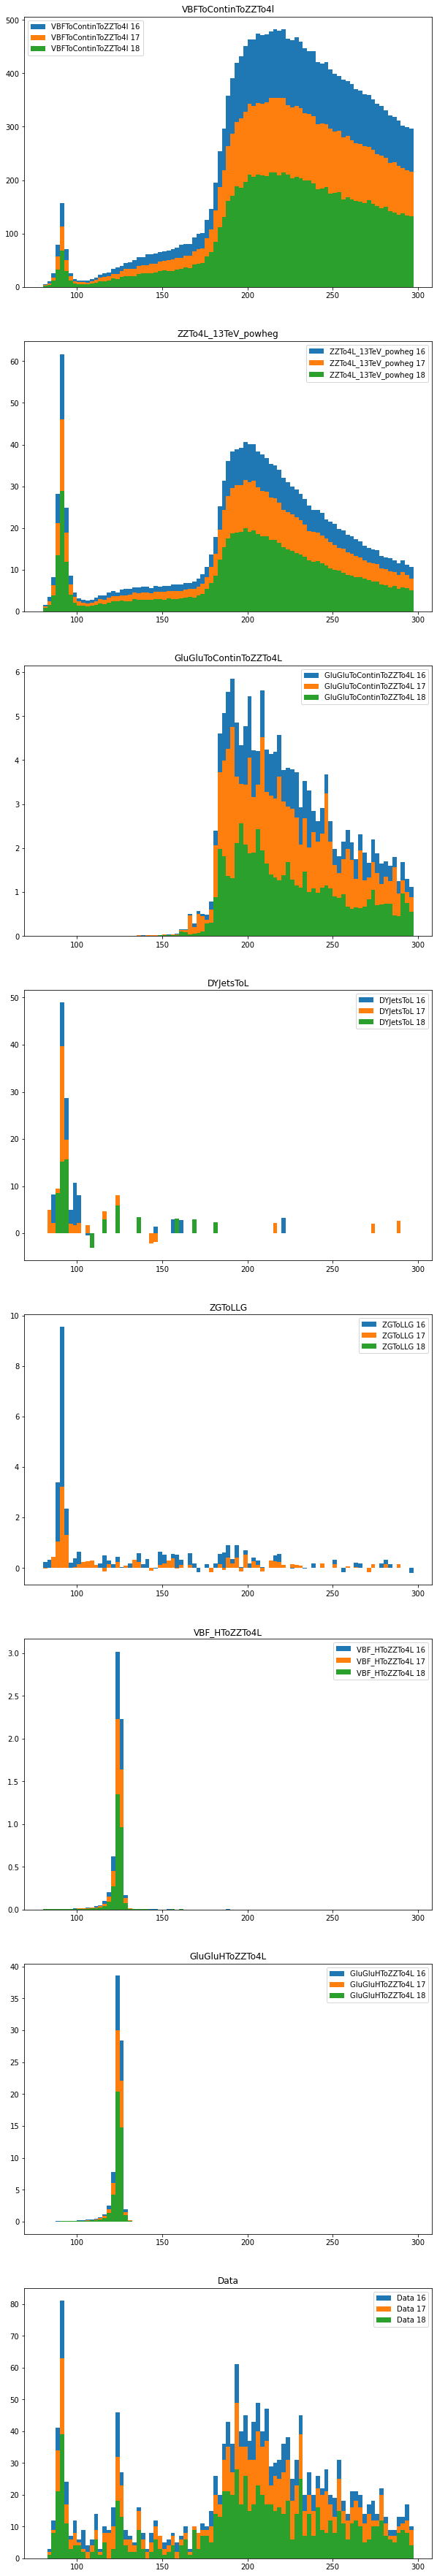

In [201]:
fileread = FileRead(num_tag = "0107_2")
fileread.histogram_by_process_by_year()

## Binned counts by lepton flavor and process
### Seperated between onshell lepton pair

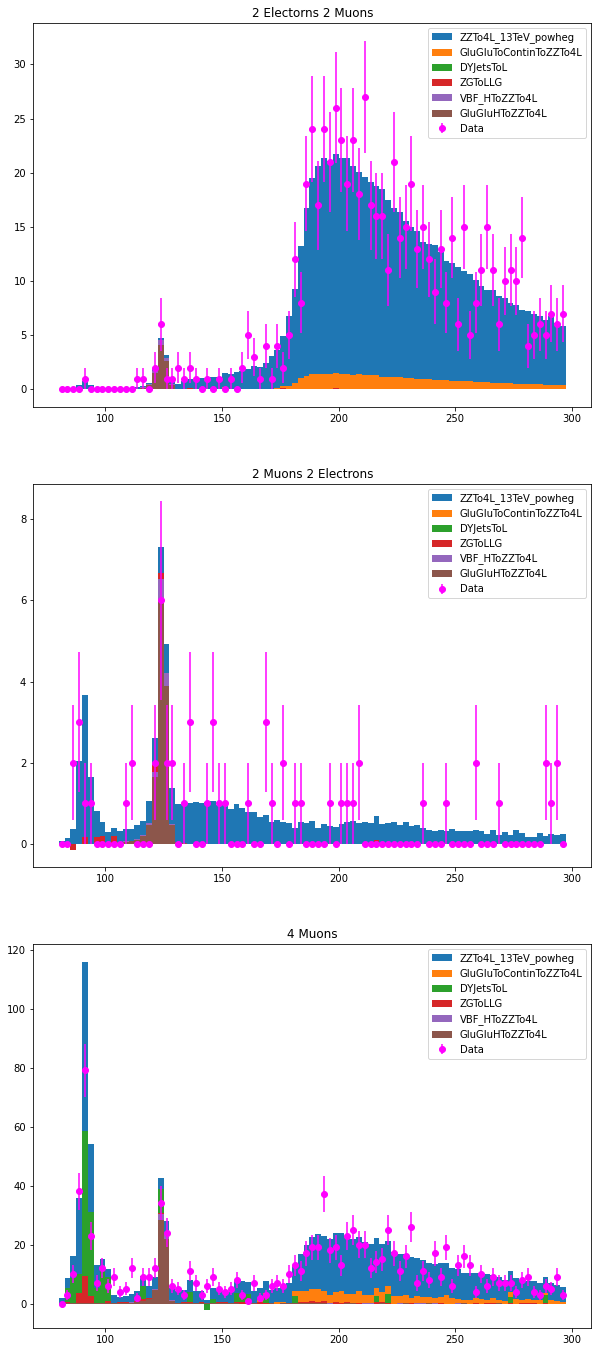

In [197]:
fileread.histogram_by_group_by_process()

### Just flavor of leptons (not onshell pair into account)

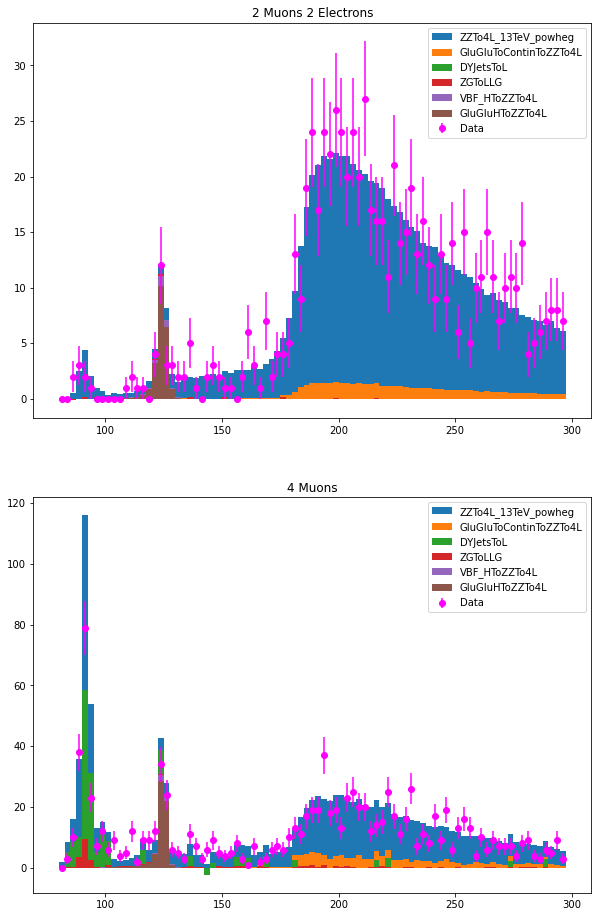

In [199]:
fileread.histogram_by_group_by_process(divide_first_pair= False)

## Total by process

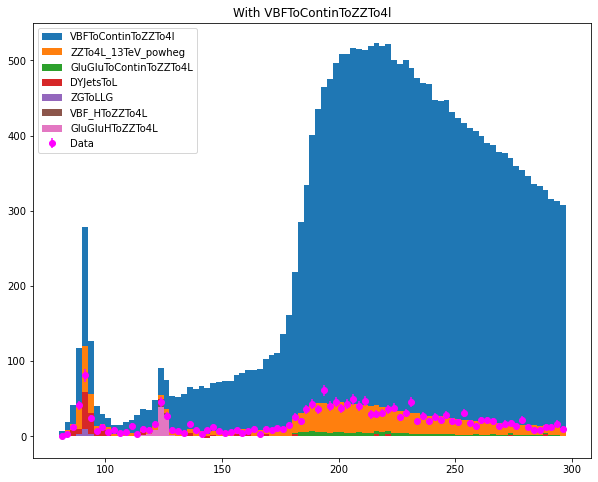

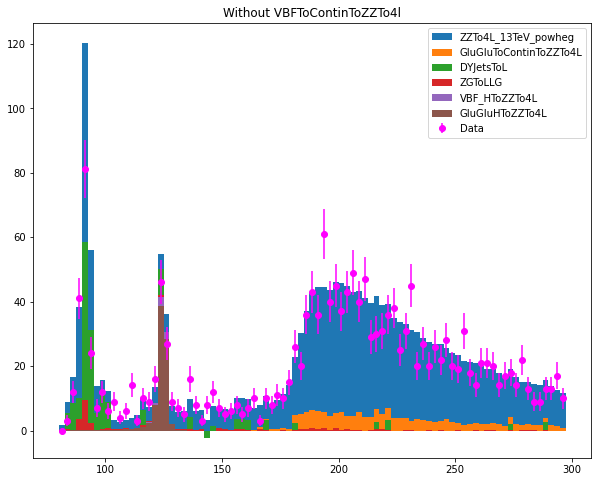

In [200]:
fileread.histogram_by_process()

# Statistical part